<a href="https://colab.research.google.com/github/DeekshaKarkada/CNN-DenseNet-201-Implementation/blob/main/CNN_DenseNet-201%20Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CT5133 Deep Learning Assignment 2

Student ID: 23104532

Student name: Deeksha Karkada

In [ ]:
import warnings

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

from keras.layers import Resizing
from keras.datasets import cifar10
from keras.utils import to_categorical, set_random_seed

warnings.filterwarnings('ignore')

In [ ]:
# remove this cell before posting
from keras.applications import MobileNetV2
from keras.models import Model, Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Input, BatchNormalization, Activation, Dropout

In [ ]:
# https://keras.io/examples/keras_recipes/reproducibility_recipes/

# Set the seed using keras.utils.set_random_seed. This will set:
# 1) `numpy` seed
# 2) backend random seed
# 3) `python` random seed
set_random_seed(0)

In [ ]:
def subsample(X, y=None, p=0.1):
    # work with a fraction of the data
    n_samples = X.shape[0]
    subsample_size = int(n_samples * p)
    idxs = np.random.choice(n_samples, subsample_size, replace=False)
    if y is None:
        return X[idxs]
    else:
        return X[idxs], y[idxs]

def visualise_embedding(X, y=None, p_subsample=None):
    """
    Visualise an embedding X as a scatterplot.

    Optionally visualise class labels y at the same time as colours.

    If X has >2 dimensions, use UMAP to reduce to 2.

    User can supply eg subsample=0.01, to show a small fraction of the data.
    """
    n_samples, n_features = X.shape

    # check X and y shapes compatible
    if y is not None:
        if n_samples != y.shape[0]:
            raise ValueError(f"X and y have incompatible shapes {X.shape} and {y.shape}")

        if len(y.shape) == 2:
            # these are probably one-hot encoded, so convert to integer
            y = np.argmax(y, axis=1)

    # work with only a fraction of the data
    if p_subsample is not None:
        if y is None:
            X = subsample(X, p_subsample)
        else:
            X, y = subsample(X, y, p_subsample)

    # ensure we have 2 dimensions, using UMAP for dim reduction if needed
    if n_features > 2:
        import umap # pip install umap-learn
        reducer = umap.UMAP()
        X = StandardScaler().fit_transform(X) # need all dimensions to be on approx same scale
        X = reducer.fit_transform(X) # UMAP reduce to 2D

    # Visualization
    colors = plt.get_cmap('tab10')  # Get a color map with 10 distinct colors

    plt.figure(figsize=(10, 8))
    for i in range(10): # for 10 classes in CIFAR-10
        indices = np.where(y == i)
        plt.scatter(X[indices, 0], X[indices, 1], label=f'Class {i}', color=colors(i))

    # reflect the dim reduction in axis labels if needed
    if n_features == 2:
        axis0_lab = "z0"
        axis1_lab = "z1"
    else:
        axis0_lab = "UMAP0"
        axis1_lab = "UMAP1"

    plt.legend()
    plt.xlabel(axis0_lab)
    plt.ylabel(axis1_lab)
    plt.show()

In [ ]:
# Load CIFAR-10 data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train.shape

(50000, 32, 32, 3)

In [ ]:
# keep only a small amount of the training data for fast prototyping
# later, we could train on all data, by commenting out this line
x_train, y_train = subsample(x_train, y_train, 0.2)

# convert image data to float16 to save some memory
x_train = x_train.astype('float16')
x_test = x_test.astype('float16')

# normalise X
x_train, x_test = x_train / 255.0, x_test / 255.0
# one-hot encode y
y_train, y_test = to_categorical(y_train, 10), to_categorical(y_test, 10)

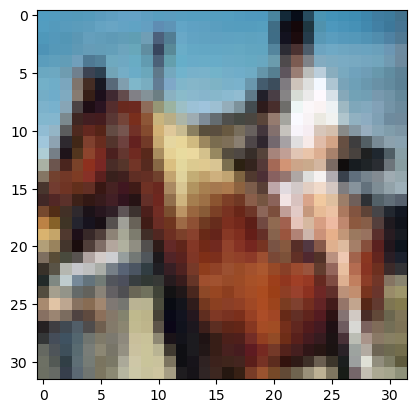

In [ ]:
plt.imshow(x_train[0].astype('float32'));

In [ ]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

# Section 2 & 3
Train the model and report performance. Ensure the training log is visible in the notebook. By looking at the training loss and validation loss, decide how many epochs are needed.

For building the convolutional network refered the lab notes provided by professor (Week 7) and twicked it as per the need of dataset and for better accuracy score

In [ ]:
num_classes = 10
kernel_size = (3, 3)
input_shape = (32, 32, 3)
z = 2

def cnn_model(input_shape, num_classes, kernel_size, z):
    model = keras.Sequential(
    [
        # we specify the layers as a Python list, where each element is a constructor call

        # an Input layer is just there to tell Keras the expected shape
        keras.Input(shape=input_shape),

        # a typical Conv block
        layers.Conv2D(32, kernel_size=kernel_size, activation="softmax"),
        layers.MaxPooling2D(pool_size=(2, 2)),

        # another Conv block
        layers.Conv2D(64, kernel_size=kernel_size, activation="softmax"),
        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Conv2D(128, kernel_size=kernel_size, activation="softmax"),
        layers.MaxPooling2D(pool_size=(2, 2)),

        # Flatten converts an "image" (height, width, n_channels) to a flat array height x width x n_channels
        layers.Flatten(),

        # Dropout is a regulariser
        layers.Dropout(0.5),

        # a standard classification head
        layers.Dense(z, activation="softmax"),
        layers.Dense(num_classes, activation='relu')
    ]
    )
    return model

In [ ]:
model1 = cnn_model(input_shape, num_classes, kernel_size, z)
model1.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model1.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 15, 15, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 2, 2, 128)         

In [ ]:
batch_size = 32
history = model1.fit(x_train, y_train, batch_size=batch_size, epochs=15, validation_data = (x_test, y_test))

Epoch 1/15


313/313 [==============================] - 10s 25ms/step - loss: 10.3198 - accuracy: 0.0975 - val_loss: 10.2260 - val_accuracy: 0.1000
Epoch 2/15
313/313 [==============================] - 6s 18ms/step - loss: 10.2866 - accuracy: 0.1059 - val_loss: 10.2170 - val_accuracy: 0.1265
Epoch 3/15
313/313 [==============================] - 6s 19ms/step - loss: 9.1639 - accuracy: 0.1110 - val_loss: 8.8550 - val_accuracy: 0.1222
Epoch 4/15
313/313 [==============================] - 6s 20ms/step - loss: 8.8890 - accuracy: 0.1227 - val_loss: 8.8405 - val_accuracy: 0.1035
Epoch 5/15
313/313 [==============================] - 5s 18ms/step - loss: 8.8694 - accuracy: 0.1109 - val_loss: 8.8274 - val_accuracy: 0.1086
Epoch 6/15
313/313 [==============================] - 8s 26ms/step - loss: 8.8540 - accuracy: 0.1185 - val_loss: 8.8405 - val_accuracy: 0.1064
Epoch 7/15
313/313 [==============================] - 6s 20ms/step - loss: 8.8585 - accuracy: 0.1334 - val_loss: 8.8189 - val_accuracy:

In [ ]:
score = model1.evaluate(x_train, y_train, verbose=0)
print("Train loss:", score[0])
print("Train accuracy:", score[1])

score = model1.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Train loss: 6.140924453735352
Train accuracy: 0.15889999270439148
Test loss: 6.0979084968566895
Test accuracy: 0.14880000054836273


In [ ]:
def plt_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()
    plt.show()

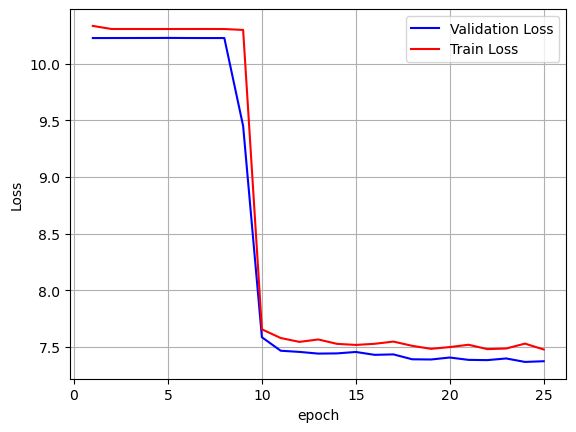

In [ ]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Loss')

# list of epoch numbers
x = list(range(1,26))
vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)
plt.show()

# Section 4
Visualise the output of the penultimate Dense(z) layer, on a subset of test data. One approach could use the supplied visualise_embedding function.

Used the already provided function visualize_plot function to get the visualization. used the input and dense output of the network layers and used them as parameters for calling the function

In [ ]:
def visualize_plot(model, dense=None):
    model_output = Model(inputs=model.input, outputs = model.get_layer(dense).output)
    embedding = model_output.predict(x_test)
    result = visualise_embedding(embedding, y=y_test, p_subsample=None)
    return result

313/313 [==============================] - 2s 7ms/step


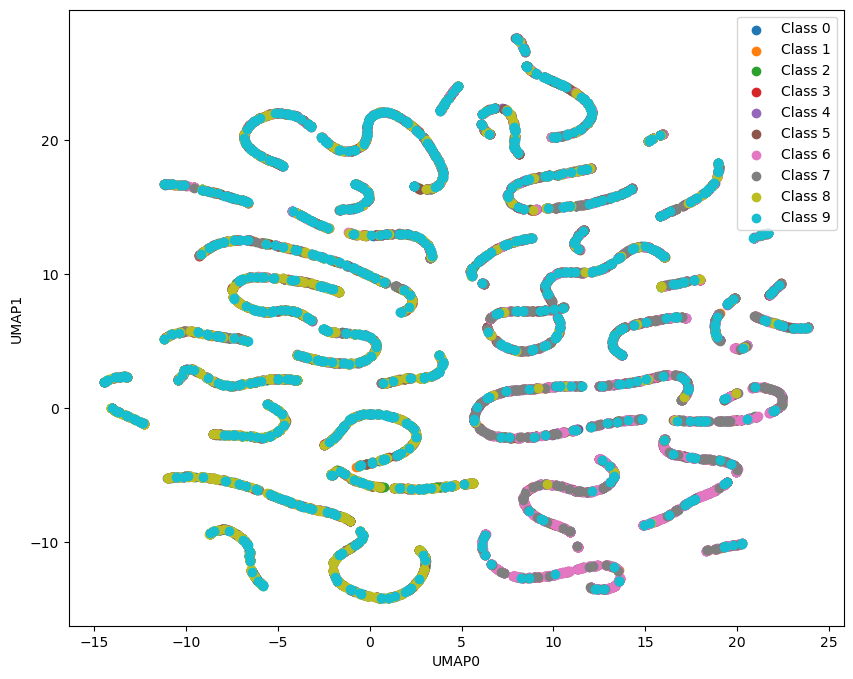

In [ ]:
result = visualize_plot(model1, dense='dense_2')
result

# Section 5
Repeat Steps 3-4 for some variants of the network: try z=2 and z=10, and try some changes in architecture such as using different kernel parameters, more or different layers, or a different optimiser. And/or try using different fractions of the data during training.

Used - kernel_size as (3,3), z=7 and SGD optimizer with a learning rate of 0.01, ref - https://keras.io/api/optimizers/

In [ ]:
num_classes = 10
kernel_size = (3,3)
input_shape = (32, 32, 3)
z = 7

optimizer = keras.optimizers.SGD(learning_rate=0.001)
model2 = cnn_model(input_shape, num_classes, kernel_size, z)
model2.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 15, 15, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 2, 2, 128)        

In [ ]:
batch_size = 32
history = model2.fit(x_train, y_train, batch_size=batch_size, epochs=15, validation_split=0.1)

Epoch 1/15
282/282 [==============================] - 6s 20ms/step - loss: 6.2163 - accuracy: 0.0943 - val_loss: 6.2634 - val_accuracy: 0.0890
Epoch 2/15
282/282 [==============================] - 5s 19ms/step - loss: 6.2022 - accuracy: 0.1016 - val_loss: 6.2580 - val_accuracy: 0.0900
Epoch 3/15
282/282 [==============================] - 3s 12ms/step - loss: 6.2008 - accuracy: 0.1014 - val_loss: 6.2566 - val_accuracy: 0.0900
Epoch 4/15
282/282 [==============================] - 5s 17ms/step - loss: 6.2007 - accuracy: 0.0981 - val_loss: 6.2563 - val_accuracy: 0.0900
Epoch 5/15
282/282 [==============================] - 5s 16ms/step - loss: 6.2007 - accuracy: 0.1021 - val_loss: 6.2565 - val_accuracy: 0.0900
Epoch 6/15
282/282 [==============================] - 4s 16ms/step - loss: 6.2007 - accuracy: 0.1024 - val_loss: 6.2569 - val_accuracy: 0.0890
Epoch 7/15
282/282 [==============================] - 3s 12ms/step - loss: 6.2006 - accuracy: 0.1037 - val_loss: 6.2566 - val_accuracy: 0.0900

313/313 [==============================] - 3s 8ms/step


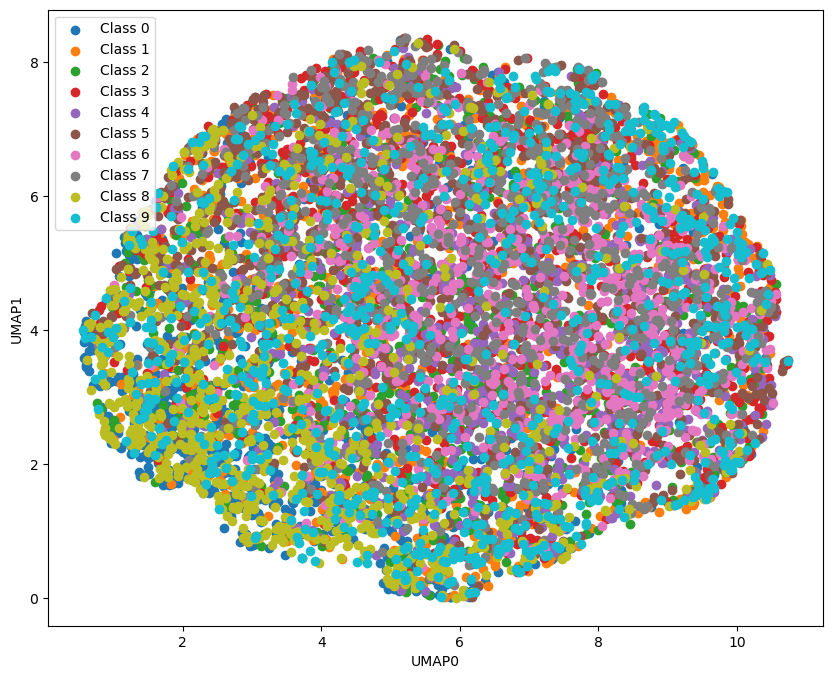

In [ ]:
result = visualize_plot(model2, dense='dense_3')
result

# Section 6
Load a pretrained model, freeze it, discard its classification head, and add a new classification head suitable for the task. Again repeat Steps 3-4 for this network.

Ref - https://khawlajlassi.medium.com/a-guide-to-transfer-learning-with-keras-using-densenet201-48c617ceb2e2 for understanding how to freeze the head, and add layers for the model

In [ ]:
import tensorflow as tf

input_tensor = tf.keras.Input(shape=(32, 32, 3))
# resize images to the image size upon which the network

resized_images = tf.keras.layers.Lambda(lambda image: tf.image.resize(image, (224, 224)))(input_tensor)
base_model = tf.keras.applications.DenseNet201(include_top=False,
                                   weights='imagenet',
                                   input_tensor=resized_images,
                                   input_shape=(224, 224, 3),
                                   pooling='max',
                                   classes=500)

for layer in base_model.layers:
    layer.trainable = False

base_model.trainable = False

In [ ]:
initializer = tf.keras.initializers.he_normal()
input_tensor = tf.keras.Input(shape=(32, 32, 3))
resized_images = tf.keras.layers.Lambda(lambda image: tf.image.resize(image, (224, 224)))(input_tensor)

In [ ]:
model = tf.keras.Sequential()
model.add(base_model)

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(units=256,
                           activation='relu'))
                           #kernel_initializer=initializer,
                           #kernel_regularizer=tf.keras.regularizers.l2()))

model.add(tf.keras.layers.Dropout(0.6))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(units=256,
                           activation='relu'))
                           #kernel_initializer=initializer,
                           #kernel_regularizer=tf.keras.regularizers.l2()))

model.add(tf.keras.layers.Dense(units=num_classes, activation='softmax'))
                               #kernal_initializer = initializer,
                               #kernal_regularizer = tf.keras.regularizers.l2()))

In [ ]:
model.compile(
         optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
         loss='categorical_crossentropy',
         metrics=['accuracy'])

In [ ]:

history = model.fit(x_train, y_train,
                    #steps_per_epoch=train_steps_per_epoch,
                    validation_data = (x_test, y_test),
                    batch_size = 32,
                    epochs=6,
                    shuffle=True,
                    verbose=1)

Epoch 1/6
313/313 [==============================] - 1227s 4s/step - loss: 1.1445 - accuracy: 0.6221 - val_loss: 0.7873 - val_accuracy: 0.7272
Epoch 2/6
313/313 [==============================] - 1307s 4s/step - loss: 0.8356 - accuracy: 0.7188 - val_loss: 0.7298 - val_accuracy: 0.7425
Epoch 3/6
313/313 [==============================] - 1318s 4s/step - loss: 0.7627 - accuracy: 0.7376 - val_loss: 0.6825 - val_accuracy: 0.7666
Epoch 4/6
313/313 [==============================] - 1224s 4s/step - loss: 0.7244 - accuracy: 0.7560 - val_loss: 0.6246 - val_accuracy: 0.7960
Epoch 5/6
313/313 [==============================] - 1164s 4s/step - loss: 0.6967 - accuracy: 0.7600 - val_loss: 0.5983 - val_accuracy: 0.7999
Epoch 6/6
313/313 [==============================] - 1149s 4s/step - loss: 0.6741 - accuracy: 0.7731 - val_loss: 0.5652 - val_accuracy: 0.8080


In [ ]:
print("Accuracy socre:", np.max(history.history['val_accuracy']))

Accuracy socre: 0.8080000281333923


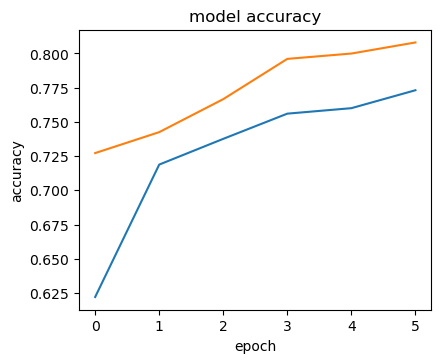

In [ ]:
plt.figure(1, figsize = (10,8))
plt.subplot(221)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

313/313 [==============================] - 537s 2s/step


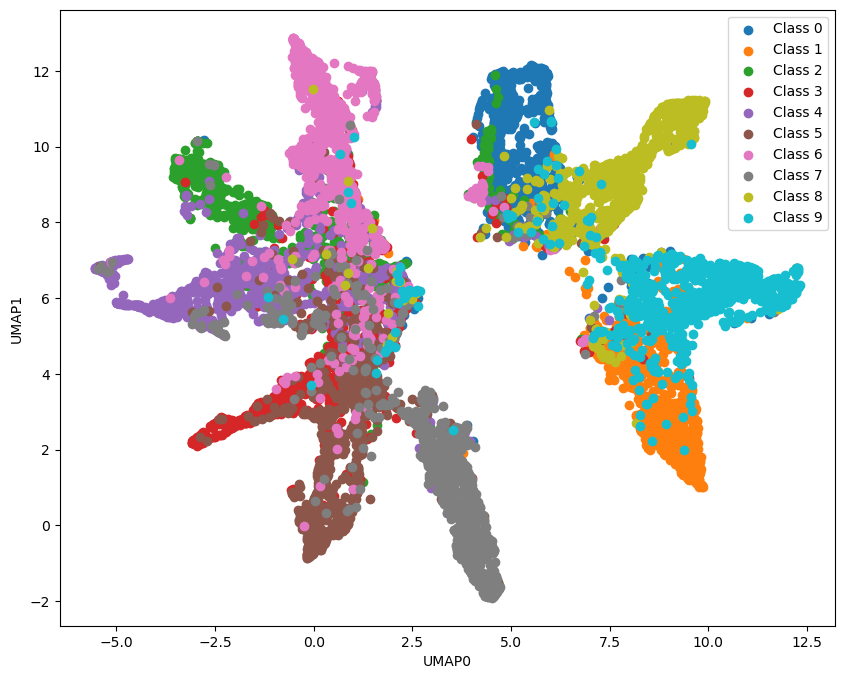

In [ ]:
result = visualize_plot(model, dense='dense_20')
result

# Summary

Model1  -  Used z=2 and ran the model for dense - 10 on the final layer, then used the plot to see the loss against epoch curve.
Made use of the vizualise_embedding function already provided and provided the dense layer outputs for the plot

Model2 - ran for z=2 & z=7 and changed the optimizer to sgd and kernel_size=(3,3) and plot the curve for that as well.

Pretrained model - used DenseNet201 (https://keras.io/api/applications/densenet/#densenet201-function) and trained after resizing the images to (224, 224).
freezed the classification head for this using include_top=False and used 2 dense layers in the model.

From all the visualizations it can be conclued that pre trained model was able to perform better and classify the labels much better that the models with z = 2 & z = 7